In [1]:
import boto3
import numpy as np
import pygrib
import polars as pl
from datetime import datetime, timedelta
import HDA
import warnings
from scipy.interpolate import griddata
import calendar
import pandas as pd
import cfgrib
import os 
import functools as ft
import yaml

/home/eouser/dedl/lib/python3.10/site-packages/ecmwflibs/__init__.py:61: UserWarning: ecmwflibs: using provided 'ECCODES_DEFINITION_PATH' set to '/usr/share/eccodes/share/eccodes/definitions
  warnings.warn(


In [2]:
with open('/home/eouser/Desktop/DEDL/credentials.yaml', 'r') as f:
    credentials = yaml.safe_load(f)
    
    
S3_BASE_URL = "https://s3.{site_name}.data.destination-earth.eu"

S3_URL_CENTRAL = S3_BASE_URL.format(site_name="central")
S3_URL_LUMI = S3_BASE_URL.format(site_name="lumi")

session = boto3.Session(
        aws_access_key_id=credentials["lumi"]["key"],
        aws_secret_access_key=credentials["lumi"]["secret"],
        region_name='DEDL-LUMI'
)

s3_central = session.client('s3', endpoint_url=S3_URL_CENTRAL)
s3_lumi = session.client('s3', endpoint_url=S3_URL_LUMI)

bytes_data =  s3_lumi.get_object(Bucket='era5-data', Key='2023/202308_42.9_0.1_40.5_3.4.grib')['Body'].read()
bytes_data_sp =  s3_lumi.get_object(Bucket='era5-data', Key='2023/202308_42.9_0.1_40.5_3.4_sp.grib')['Body'].read()

## GRIB file to pandas dataframe

In [3]:
def grib2df(bytes_data, filename):
    messages = bytes_data.split(b'7777')[:-1]
    
    month = filename.split("/")[-1][4:6]
    year = filename.split("/")[-1][:4]
    days = calendar.monthrange(int(year), int(month))[1]
    
    slc = len(messages)//(24 * days)
    df_ = pl.DataFrame()

    for i in range(0,len(messages),slc):
        try:
            data = {
                'latitude': [],
                'longitude': [],
                'time': []
            }
            for message in messages[i:i+slc]:
                grb = pygrib.fromstring(message + b'7777')
                data_array = np.where(grb.values.data == 9999, np.nan, grb.values.data)
                data.update({grb.shortName: data_array.flatten()})

            lats, lons = map(lambda x: np.round(x, 1), grb.latlons())
            if len(str(grb.validityTime)) < 4:
                time = datetime.strptime(f"{grb.validityDate} 0{grb.validityTime}", '%Y%m%d %H%M')
            else:
                time = datetime.strptime(f"{grb.validityDate} {grb.validityTime}", '%Y%m%d %H%M')
                
            # Flatten arrays and append data
            data['latitude'].extend(lats.flatten())
            data['longitude'].extend(lons.flatten())
            data['time'].extend([time] * len(data_array.flatten()))
            
            # Convert data to Polars DataFrame and concatenate
            df_ = pl.concat([df_, pl.DataFrame(data)]) 
        except:
            print(f"Error in message {i}")

    return df_

In [4]:
era_5 = {x['CDSShortName']:x['name'] for x in HDA.era5.variables}
df_era5 = grib2df(bytes_data,'2023/202307_42.9_0.1_40.5_3.4.grib')

era_5.update({'sp':'surfacePressure'})
df_sp = grib2df(bytes_data_sp,'2023/202307_42.9_0.1_40.5_3.4_sp.grib')

df_ = df_era5.join(df_sp, on=["latitude", "longitude", "time"], how="left")


In [5]:
filter = df.filter(pl.col('time') == pl.datetime(2023, 7, 26,5,0))
filter_coords = filter.select(['latitude','longitude']).to_numpy()
filter_coords = set(map(tuple,filter_coords))

NameError: name 'df' is not defined

In [21]:
len(df.select(['latitude','longitude']).unique().to_numpy())

558

In [22]:
len(filter.select(['latitude','longitude']).unique().to_numpy())

557

In [25]:
group_coords = filter.select(['latitude', 'longitude'])
df_coords = df.select(['latitude', 'longitude']).unique()

# Convert to sets of tuples for comparison
group_set = set(map(tuple, group_coords.to_numpy()))
df_set = set(map(tuple, df_coords.to_numpy()))

# Find missing values in df compared to group_df
missing_in_df =  df_set -group_set

# Convert the result back to a DataFrame for better readability
# missing_df = pl.DataFrame(missing_in_df, schema=['latitude', 'longitude'])
missing_in_df

{(42.5, 2.0)}

## Cleaning pipeline

In [14]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Load the shapefile
postalcodes_path = '/home/eouser/Desktop/SpanishPostalCodes/Catalonia/postal_codes.shp'
gdf = gpd.read_file(postalcodes_path)
gdf = gdf.to_crs(epsg=4326)
print(f"Number of postal codes: {len(gdf['COD_POSTAL'].unique())}")

display(gdf)
# gdf.explore("area",legend=False)


Number of postal codes: 1137


,COD_POSTAL,ID_CP,ALTA_DB,CODIGO_INE,geometry
0,08001,80190000034,2015-07-09,8019,"POLYGON ((2.16767 41.38594, 2.16981 41.38569, ..."
1,08002,80190000033,2015-07-09,8019,"POLYGON ((2.17281 41.38821, 2.17433 41.38705, ..."
2,08003,80190000041,2015-07-09,8019,"POLYGON ((2.19183 41.37592, 2.19032 41.37523, ..."
3,08004,80190000039,2015-07-09,8019,"POLYGON ((2.16787 41.37503, 2.17281 41.37479, ..."
4,08005,80190000042,2015-07-09,8019,"POLYGON ((2.22885 41.40958, 2.22577 41.40529, ..."
...,...,...,...,...,...
1132,43893,430120000001,2015-07-09,43012,"POLYGON ((1.39565 41.16728, 1.3952 41.16672, 1..."
1133,43894,439030000001,2015-07-09,43903,"POLYGON ((0.6378 40.75916, 0.63643 40.76275, 0..."
1134,43895,439060000001,2015-07-09,43906,"POLYGON ((0.65794 40.79802, 0.65793 40.79803, ..."
1135,43896,439040000001,2015-07-09,43904,"POLYGON ((0.6378 40.75916, 0.63781 40.75911, 0..."


Removee missing values

In [15]:
pandas_dataframe = df_.to_pandas()
df_null = pandas_dataframe.where(pd.notnull(pandas_dataframe), None)
df = df_null[-df_null.isnull().any(axis=1)]
df = pl.from_pandas(df)
df

latitude,longitude,time,10u,10v,2d,2t,lai_hv,lai_lv,tp,ssrd,fal,stl4,swvl4,sp
f64,f64,datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
42.9,0.1,2023-07-01 00:00:00,0.520676,-0.042635,277.47168,280.232666,4.756348,2.029785,0.001804,2.2961652e7,0.168672,280.581543,0.440186,82060.625
42.9,0.2,2023-07-01 00:00:00,0.538254,0.025724,277.780273,280.5979,4.418701,2.239014,0.001746,2.244512e7,0.166047,281.089355,0.417328,82730.625
42.9,0.3,2023-07-01 00:00:00,0.549973,0.128263,278.706055,281.365479,2.991211,3.230225,0.001671,2.1857668e7,0.158082,282.446777,0.415024,84433.625
42.9,0.4,2023-07-01 00:00:00,0.563644,0.213224,280.393555,282.386963,3.233765,3.171875,0.001643,2.1259684e7,0.147279,283.429199,0.415802,86952.625
42.9,0.5,2023-07-01 00:00:00,0.581223,0.198576,281.413086,282.965088,3.37854,3.158081,0.001856,2.057462e7,0.153001,283.931152,0.414612,88463.625
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
40.5,0.1,2023-07-31 23:00:00,1.524033,0.53096,295.574219,296.575684,2.379395,2.387329,0.0011,1.660966e7,0.156966,292.453857,0.252853,94504.5
40.5,0.2,2023-07-31 23:00:00,1.51622,0.976273,296.220703,297.634277,2.316284,2.219482,0.000561,1.7071986e7,0.167693,293.078857,0.225357,96607.5
40.5,0.3,2023-07-31 23:00:00,1.424423,1.357132,296.683594,298.493652,2.100952,2.072754,0.000664,1.7526374e7,0.181304,293.481201,0.206711,98585.5


Data ingestion

In [18]:
pandas_dataframe = df_new.to_pandas()
df_null = pandas_dataframe.where(pd.notnull(pandas_dataframe), None)
df0 = df_null[-df_null.isnull().any(axis=1)]
df0 = pl.from_pandas(df0)
df0

latitude,longitude,depthBelowLandLayer,time,soilWaterRatio,soilTemperature,lowVegetationRatio,highVegetationRatio,surfacePressure,windSpeedEast,windSpeedNorth,airTemperature,dewAirTemperature,strd,totalPrecipitation,albedo
f64,f64,f64,datetime[ns],f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
42.5,0.1,100.0,2023-07-11 05:00:00,0.363754,285.819824,2.902954,2.287964,90456.8125,-0.74968,-0.163223,295.474854,286.411133,5.994767e6,0.0,0.118459
42.5,0.2,100.0,2023-07-11 05:00:00,0.359177,285.399902,2.866943,2.227417,89538.8125,-0.683273,-0.040176,295.008057,285.922852,5.951515e6,0.0,0.131658
42.5,0.3,100.0,2023-07-11 05:00:00,0.347916,284.618652,2.850098,2.282471,87635.8125,-0.651047,0.025253,293.781494,284.831055,5.914308e6,0.0,0.139349
42.5,0.4,100.0,2023-07-11 05:00:00,0.333008,283.790527,2.877075,2.338867,85448.8125,-0.668625,-0.001114,292.209229,283.583008,5.886622e6,0.0,0.133657
42.5,0.5,100.0,2023-07-11 05:00:00,0.357422,282.853027,2.593872,3.371704,85136.8125,-0.638351,0.070175,292.201416,283.80957,5.847614e6,0.0,0.145986
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
40.9,1.6,100.0,2023-07-26 05:00:00,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0
40.9,1.7,100.0,2023-07-26 05:00:00,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0
40.9,1.8,100.0,2023-07-26 05:00:00,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0


In [27]:
lat1 = df.select(['latitude', 'longitude']).unique()["latitude"] # 558
lon1 = df.select(['latitude', 'longitude']).unique()["longitude"] # 558
features = df.drop(['time','latitude', 'longitude']).columns # 12
points = np.array(list(zip(lat1, lon1))) # 558,2

gdf = gdf.to_crs(epsg=4326)
gdf['centroid'] = gdf.geometry.centroid
lat2 = gdf['centroid'].y # 1137
lon2 = gdf['centroid'].x # 1137
postalcodes = gdf['COD_POSTAL'] # 1137
grid_points = np.array(list(zip(lat2, lon2))) # 1137,2


dfs =[]
for group_name, group_df in df.group_by(["time"]): #2021-07-15 05:00
    result_df = pl.DataFrame({
        'postalCode': postalcodes, # 1137
        'latitude': lat2, # 1137
        'longitude': lon2, # 1137
        'time': group_name * len(lon2) # 1137
    })
    for feature in features:
        values = group_df[feature] # 557 10u
        interpolated_values = griddata(points, values, grid_points, method='linear')
        nearest_values = griddata(points, values, grid_points, method='nearest')
        interpolated_values = np.where(np.isnan(interpolated_values), nearest_values, interpolated_values)
        result_df.insert_column(-1,pl.Series(feature,interpolated_values))

    dfs.append(result_df)
    
df_interp = pl.concat(dfs)

NameError: name 'gdf' is not defined

In [37]:
norm = df.filter(pl.col('time') == pl.datetime(2021, 7, 15))

In [41]:
group_coords = group_df.select(['latitude', 'longitude'])
df_coords = norm.select(['latitude', 'longitude'])

# Convert to sets of tuples for comparison
group_set = set(map(tuple, group_coords.to_numpy()))
df_set = set(map(tuple, df_coords.to_numpy()))

# Find missing values in df compared to group_df
missing_in_df =  df_set -group_set

# Convert the result back to a DataFrame for better readability
# missing_df = pl.DataFrame(missing_in_df, schema=['latitude', 'longitude'])
missing_in_df

{(41.6, 0.7)}

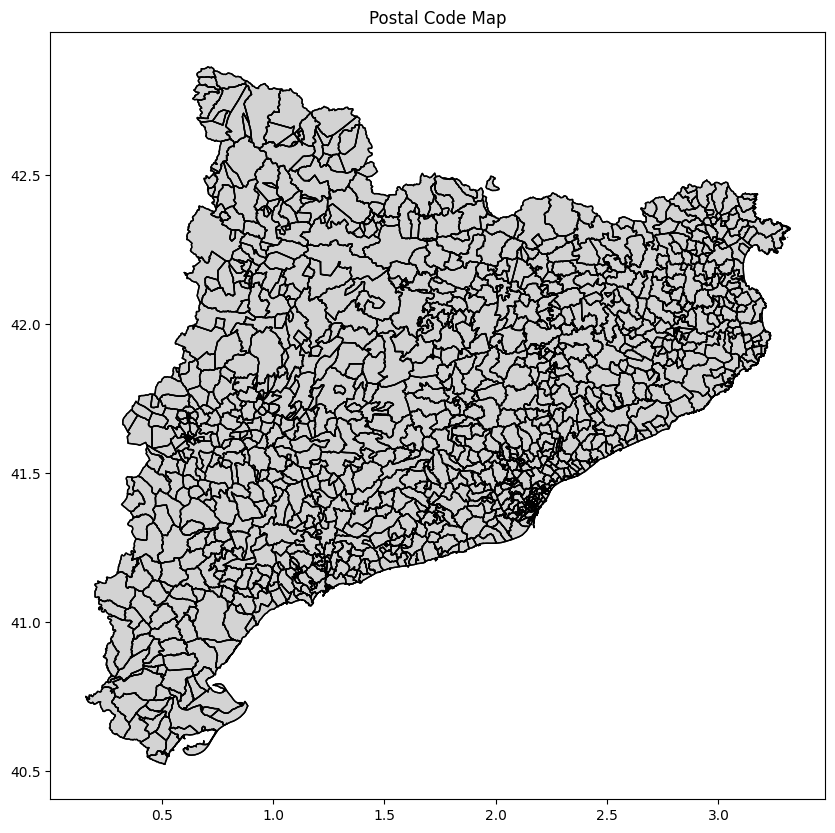

In [17]:
import matplotlib.pyplot as plt

pandas_dataframe = df_interp.to_pandas()
df_null = pandas_dataframe.where(pd.notnull(pandas_dataframe), None)
nulls = df_null[df_null.isnull().any(axis=1)]
postal_codes = pd.unique(nulls['postalCode'])

gdf['color'] = gdf['COD_POSTAL'].apply(lambda x: 'red' if x in postal_codes else 'lightgrey')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.boundary.plot(ax=ax, linewidth=1, color='white')  # Plot boundaries
gdf.plot(ax=ax, color=gdf['color'], edgecolor='white')  # Plot colored postal codes

# Add title and show the plot
plt.title('Postal Code Map')
plt.show()

Compute the number of meteorological stations within catalonia

Number of meteorological stations within Catalonia: 349


<Axes: >

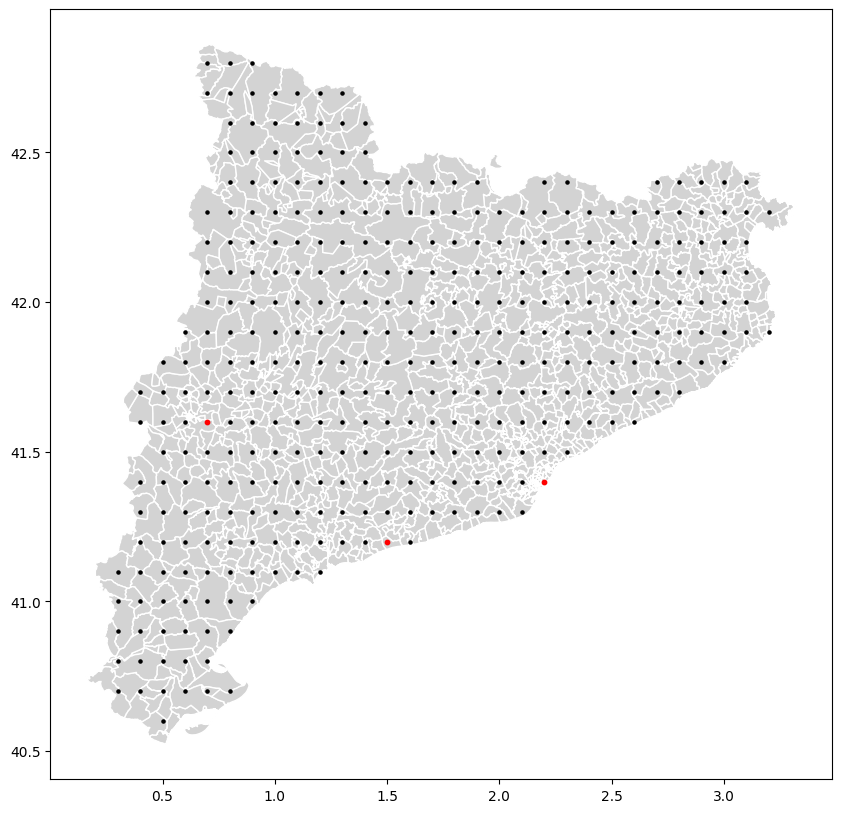

In [42]:
import matplotlib.pyplot as plt

latslons = df_.unique(subset=['latitude', 'longitude'])['latitude','longitude']
geometry = [Point(lon, lat) for lon, lat in zip(latslons['longitude'], latslons['latitude'])]
geo_df = gpd.GeoDataFrame(latslons, geometry=geometry, crs='EPSG:4326')

filtered_gdf = geo_df[geo_df.geometry.within(gdf.union_all())]
filter = pl.DataFrame(filtered_gdf.drop(columns='geometry'))
filter = filter.rename({'0':'latitude','1':'longitude'})
print(f"Number of meteorological stations within Catalonia: {len(filter)}")

highlight_points = [(2.6,41.6), (2.2, 41.4), (1.5, 41.2)]
highlight_gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in highlight_points], crs='EPSG:4326')

fig, ax = plt.subplots(figsize=(12, 10)) 
ax = gdf["geometry"].plot(ax=ax, color="lightgray", edgecolor="white")
filtered_gdf.plot(ax=ax, color="black",markersize=5)
highlight_gdf.plot(ax=ax, color="red", markersize=10)

In [19]:
df_ = df_.join(filter, on=['latitude', 'longitude'], how='inner')
df_ = df_.fill_nan(None)
print(f"Number of null values: {df_.null_count()}")
print(f"Original shape: {df_.shape}")
df_ = df_.drop_nulls()
df_ = df_.rename(era_5)
print(f"Current shape: {df_.shape}")

Number of null values: shape: (1, 15)
┌──────────┬───────────┬──────┬──────┬───┬──────┬──────┬───────┬──────┐
│ latitude ┆ longitude ┆ time ┆ 10u  ┆ … ┆ fal  ┆ stl4 ┆ swvl4 ┆ sp   │
│ ---      ┆ ---       ┆ ---  ┆ ---  ┆   ┆ ---  ┆ ---  ┆ ---   ┆ ---  │
│ u32      ┆ u32       ┆ u32  ┆ u32  ┆   ┆ u32  ┆ u32  ┆ u32   ┆ u32  │
╞══════════╪═══════════╪══════╪══════╪═══╪══════╪══════╪═══════╪══════╡
│ 0        ┆ 0         ┆ 0    ┆ 2232 ┆ … ┆ 2232 ┆ 2232 ┆ 2232  ┆ 2232 │
└──────────┴───────────┴──────┴──────┴───┴──────┴──────┴───────┴──────┘
Original shape: (259656, 15)
Current shape: (257424, 15)


In [20]:
import pvlib

df = df_
df = df.sort(["latitude", "longitude", "time"])
df = df.with_columns([
    np.sqrt(pl.col("windSpeedEast") ** 2 + pl.col("windSpeedNorth") ** 2).alias("windSpeed"),
    ((180 + np.degrees(np.arctan2(pl.col("windSpeedEast"), pl.col("windSpeedNorth")))) % 360).alias("windDirection"),
    (pl.col("soilTemperature") - 273.15).alias("soilTemperature"),
    (pl.col("dewAirTemperature") - 273.15).alias("dewAirTemperature"),
    (pl.col("airTemperature") - 273.15).alias("airTemperature")
])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df = df.with_columns(
        pl.when(pl.col("airTemperature").is_null() | pl.col("dewAirTemperature").is_null())
        .then(None)
        .otherwise(100* np.exp((17.625 *  pl.col("dewAirTemperature")) / (243.04 +  pl.col("dewAirTemperature")))/
                   np.exp((17.625 * pl.col("airTemperature")) / (243.04 + pl.col("airTemperature")))
                   ).alias("relativeHumidity")
    )
    
# Accummulative parameters: https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Table3
acumm =  ['totalPrecipitation', 'GHI']
df = df.with_columns(
    pl.when(pl.col("time") == df.select(pl.col("time").min()).item())
    .then(0)
    .when(pl.col("time") == df.select(pl.col("time").max()).item())
    .then(0)
    .otherwise((pl.col("GHI").shift(-1) - pl.col("GHI")) / 3600)
    .alias("GHI_avg")
)
df = df.with_columns(
    pl.when(pl.col("time") == df.select(pl.col("time").min()).item())
    .then(0)
    .when(pl.col("time") == df.select(pl.col("time").max()).item())
    .then(pl.col("totalPrecipitation"))
    .otherwise((pl.col("totalPrecipitation").shift(-1) - pl.col("totalPrecipitation")) * 1000)
    .alias("totalPrecipitation_avg")
)
df = df.with_columns(
    pl.when(pl.col("GHI_avg") > 0)
    .then(pl.col("GHI_avg"))
    .otherwise(0)
    .alias("GHI_avg")
)
df = df.with_columns(
    pl.when(pl.col("totalPrecipitation_avg") > 0)
    .then(pl.col("totalPrecipitation_avg"))
    .otherwise("totalPrecipitation")
    .alias("totalPrecipitation_avg")
)

# Instantaneous parameters: https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Table2
analysis = [x for x in era_5.values() if x not in acumm] + ["windSpeed"] + ["windDirection"] + ["relativeHumidity"]
print(analysis)
for var in analysis:
    df = df.with_columns(
        pl.when(pl.col("time") < df.select(pl.col("time").max()).item())
        .then((pl.col(var).shift(-1) + pl.col(var)) / 2)
        .otherwise(pl.col(var))
        .alias(f"{var}_avg")
    )
print(f"Before drop: {len(df)}")

df = df.drop(analysis)
df = df.drop(acumm)
rename_map = {col: col.replace("_avg", "") for col in df.columns if col.endswith("_avg")}
df = df.rename(rename_map)
print(f"After drop: {len(df)}")
def join_solar_data(df):
    dfp = df.to_pandas()
    location = pvlib.location.Location(
        latitude=df.select("latitude").unique().item(),
        longitude=df.select("longitude").unique().item())
    solar_df = location.get_solarposition(
        dfp['time'] + pd.Timedelta(minutes=30),
        pressure=dfp['surfacePressure'],
        temperature=dfp['airTemperature']).reset_index()
    dni = pvlib.irradiance.disc(
        ghi=dfp["GHI"],
        solar_zenith=solar_df['apparent_zenith'],
        datetime_or_doy=solar_df['time'].dt.dayofyear,
        pressure=dfp["surfacePressure"])
    rad_df = pvlib.irradiance.complete_irradiance(
        solar_zenith=solar_df['apparent_zenith'],
        ghi=dfp["GHI"],
        dni=dni["dni"],
        dhi=None).rename(columns={'ghi':'GHI','dni':'DNI','dhi':'DHI'})
    solar_df = solar_df.drop(['apparent_zenith', 'zenith', 'apparent_elevation', 'equation_of_time'], axis=1)
    solar_df = solar_df.rename(columns={'elevation': 'sunElevation', 'azimuth': 'sunAzimuth'})
    solar_df['time'] = (solar_df['time'] - pd.Timedelta(minutes=30)).astype('datetime64[us]')
    solar_df = pl.from_pandas(pd.concat([solar_df, rad_df], axis=1))

    return solar_df.join(df.drop("GHI"), on="time", how="inner")

# Loop through each group and apply the join_solar_data function
result_list = []
for group_name, group_df in df.group_by(["latitude","longitude"]):
    result = join_solar_data(group_df)
    result_list.append(result)
print(f"After res: {len(result)}")    
print(f"After sun: {len(result_list)}")    
df = pl.concat(result_list)

df

['windSpeedEast', 'windSpeedNorth', 'dewAirTemperature', 'airTemperature', 'highVegetationRatio', 'lowVegetationRatio', 'albedo', 'soilTemperature', 'soilWaterRatio', 'surfacePressure', 'windSpeed', 'windDirection', 'relativeHumidity']
Before drop: 257424
After drop: 257424
After res: 744
After sun: 346


time,sunElevation,sunAzimuth,GHI,DHI,DNI,latitude,longitude,totalPrecipitation,windSpeedEast,windSpeedNorth,dewAirTemperature,airTemperature,highVegetationRatio,lowVegetationRatio,albedo,soilTemperature,soilWaterRatio,surfacePressure,windSpeed,windDirection,relativeHumidity
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-01-01 00:00:00,-69.247303,21.187781,0.0,0.0,0.0,42.7,1.3,0.000005,0.273949,2.041374,-8.115332,0.418848,4.578308,0.724609,0.111484,7.634546,0.453629,82170.65625,2.059679,187.643092,52.77609
2023-01-01 01:00:00,-62.615997,51.405256,0.0,0.0,0.0,42.7,1.3,0.0,0.246223,2.040375,-8.327734,0.359399,4.577881,0.723999,0.11149,7.631372,0.453644,82166.1875,2.055305,186.880752,52.133084
2023-01-01 02:00:00,-52.974601,70.163925,0.0,0.0,0.0,42.7,1.3,0.0,0.204689,2.042343,-8.172217,0.379297,4.577881,0.723999,0.11149,7.628198,0.453667,82162.875,2.05266,185.722697,52.693866
2023-01-01 03:00:00,-42.259385,83.152224,0.0,0.0,0.0,42.7,1.3,0.0,0.160675,2.047241,-7.755225,0.451318,4.577881,0.723999,0.11149,7.625024,0.453674,82145.96875,2.053696,184.488664,54.14527
2023-01-01 04:00:00,-31.256474,93.584175,0.0,0.0,0.0,42.7,1.3,0.0,0.140129,2.060379,-7.286719,0.495996,4.577881,0.723999,0.11149,7.621851,0.453682,82114.71875,2.065143,183.890308,55.960509
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2023-01-31 19:00:00,-26.911428,270.383777,0.0,0.0,0.0,41.8,1.8,0.000006,0.517548,-0.897895,0.970728,5.062769,2.904297,2.656372,0.147767,10.82229,0.296249,97523.9375,1.044002,329.276133,74.91118
2023-01-31 20:00:00,-38.01471,281.138684,0.0,0.0,0.0,41.8,1.8,0.000003,0.552475,-1.193348,0.425928,3.425073,2.904297,2.656372,0.147767,10.817529,0.296257,97537.09375,1.315219,335.274178,80.817611
2023-01-31 21:00:00,-48.647749,294.405359,0.0,0.0,0.0,41.8,1.8,0.000003,0.772232,-1.351142,-0.624854,1.534204,2.904297,2.656372,0.147767,10.812769,0.296265,97538.21875,1.559735,330.465096,85.576497


## Aggregate by postal codes

In [21]:
pandas_dataframe = df.to_pandas()
df_null = pandas_dataframe.where(pd.notnull(pandas_dataframe), None)
df_null[df_null.isnull().any(axis=1)]

,time,sunElevation,sunAzimuth,GHI,DHI,DNI,latitude,longitude,totalPrecipitation,windSpeedEast,...,airTemperature,highVegetationRatio,lowVegetationRatio,albedo,soilTemperature,soilWaterRatio,surfacePressure,windSpeed,windDirection,relativeHumidity


## Load dataframe to PostgresSQL

In [22]:
from sqlalchemy import create_engine, text

In [23]:

db_name = 'template1'
db_user = 'postgres'
db_password = 'D2st3n1t34n21rth$'
db_host = 'localhost'
db_port = '5432'  # Default is usually 5432

# Create a SQLAlchemy engine
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')
table_name = "era5"

In [ ]:
def check_table_exists(engine, table_name):
    query = text(f"""
        SELECT COUNT(*)
        FROM information_schema.tables
        WHERE table_schema = 'public' AND table_name = '{table_name}'
    """)
    with engine.connect() as conn:
        result = conn.execute(query).fetchone()
        return result[0] > 0


def check_data_exists(engine,table_name,start_date, end_date):
    query = text(f"""
        SELECT COUNT(*)
        FROM "{table_name}"
        WHERE time BETWEEN '{start_date}' AND '{end_date}'
    """)
    with engine.connect() as conn:
        result = conn.execute(query).fetchone()
        return result


def upload_monthly_data(df_interp,engine,table_name):
    
    start_date = df_interp.select("time").to_series().unique().min()
    end_date = df_interp.select("time").to_series().unique().max()
    
    if check_table_exists(engine, table_name):
        
        start_date_str = start_date.strftime('%Y-%m-%d %H:%M:%S')
        end_date_str = end_date.strftime('%Y-%m-%d %H:%M:%S')
        
        if not check_data_exists(engine,table_name,start_date_str,end_date_str):
            df_interp.to_pandas().to_sql(table_name,engine,chunksize=100000, if_exists="append",index=False, method="multi")
            print(f"Monthly data for {start_date.strftime('%B, %Y')} appended successfully.")
        else:
            print(f"Data for {start_date.strftime('%B, %Y')} already exists in the table.")
    
    else:
        df_interp.to_pandas().to_sql(table_name,engine,chunksize=100000, if_exists="replace",index=False, method="multi")
        print(f"Monthly data for {start_date.strftime('%B, %Y')} uploaded successfully.")

upload_monthly_data(df_interp,engine,table_name)


In [ ]:
# df_zero_ghi = df.filter(pl.col("GHI") == 0)
# df_zero_ghi = df_zero_ghi.with_columns(
#     pl.col("time").dt.hour().alias("hour")
# )
# result = df_zero_ghi.group_by("hour").agg(
#     pl.count().alias("count_of_zeros")
# )
# result